## **Data Collection** 

In [ ]:
! git clone https://github.com/dasparagjyoti/Face_Mask.git

Cloning into 'Face_Mask'...
remote: Enumerating objects: 6601, done.
remote: Total 6601 (delta 0), reused 0 (delta 0), pack-reused 6601
Receiving objects: 100% (6601/6601), 182.32 MiB | 23.39 MiB/s, done.
Checking out files: 100% (6666/6666), done.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 47

DIRECTORY = r"/content/Face_Mask/Face_Mask_Detection/dataset"
CATEGORIES = [ "improper_mask","with_mask", "without_mask"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels)

data = np.array(data, dtype="float32")
#data = np.reshape(data,(224, 224))
labels = np.array(labels)
#labels = labels.shape((6559, 3*2))
#labels = labels.reshape((6559, 3*2))
#labels = np.array([[labels]])
#labels = np.shape((6559,3))
#labels = np.shape((6559))
#labels = np.shape(labels,(6659, 3, 2))
#labels = np.reshape(labels,(6659, 3, 2))
#labels = np.ndarray.reshape(3)
#labels = labels.reshape((6659, 3, 2))
#labels = labels.reshape((6659, 3))
#labels = labels.reshape((labels, 3))
#labels = labels.reshape((labels.shape[0], labels.shape[1], 1))
#labels = labels.reshape((labels))
#d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))
#labels = labels.reshape((0, labels.shape[1], labels.shape[2]))


#(trainX, testX, trainY, testY) = train_test_split(data, labels,
	#test_size=0.20, stratify=labels, random_state=42)

#(trainX, valX, trainY, valY) = train_test_split(data, labels,
	#test_size=0.25, stratify=labels, random_state=42)

trainX, testX, trainY, testY = train_test_split(data,labels,test_size=0.2,train_size=0.8,stratify=labels, random_state=42)
X_train, X_cv, Y_train, Y_cv = train_test_split(trainX,trainY,test_size = 0.25,train_size =0.75,stratify=trainY, random_state=42)

#x, x_test, y, y_test = train_test_split(xtrain,labels,test_size=0.2,train_size=0.8)
#x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.25,train_size =0.75)

#X_train, X_test, y_train, y_test = train_test_split(
    #X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(
    #X_train, y_train, test_size=0.25, random_state=1)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
  #test_data=(valX, valY),
  #test_steps=len(valX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
#predIdxs1 = model.predict(valX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
#predIdxs1 = np.argmax(predIdxs1, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

#print(classification_report(valY.argmax(axis=1), predIdxs1,
	#target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")



[INFO] loading images...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


9412608/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
113/113 [==============================] - 225s 2s/step - loss: 0.5803 - accuracy: 0.7688 - val_loss: 0.2935 - val_accuracy: 0.8956
Epoch 2/20
113/113 [==============================] - 218s 2s/step - loss: 0.2440 - accuracy: 0.9193 - val_loss: 0.1731 - val_accuracy: 0.9459
Epoch 3/20
113/113 [==============================] - 224s 2s/step - loss: 0.1803 - accuracy: 0.9428 - val_loss: 0.1294 - val_accuracy: 0.9610
Epoch 4/20
113/113 [==============================] - 224s 2s/step - loss: 0.1515 - accuracy: 0.9489 - val_loss: 0.1052 - val_accuracy: 0.9677
Epoch 5/20
113/113 [==============================] - 221s 2s/step - loss: 0.1256 - accuracy: 0.9604 - val_loss: 0.0991 - val_accuracy: 0.9662
Epoch 6/20
113/113 [==============================] - 222s 2s/step - loss: 0.1120 - accuracy: 0.9634 - val_loss: 0.0812 - val_accuracy: 0.9767
Epoch 7/20
113/113 [==============================] - 226s 2s/step - loss: 0.1076 - accuracy: 0.9665 - val_loss: 0.0840 - val_accuracy: 0.9745

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


#**Test Accuracy vs Validation Accuracy**

In [ ]:
loss, accuracy = model.evaluate(testX, testY, verbose=1)
loss_v, accuracy_v = model.evaluate(X_cv, Y_cv, verbose=1)
print("Validation: accuracy_v = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")



42/42 [==============================] - 37s 883ms/step - loss: 0.0363 - accuracy: 0.9887
Validation: accuracy_v = 0.988739  ;  loss_v = 0.036338
Test: accuracy = 0.978979  ;  loss = 0.057494


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
len(data)

6659

In [ ]:
len(trainX)

5327

In [ ]:
len(testX)

1332

In [ ]:
len(X_cv)

1332

## **Training and Validation Accuracy:-**

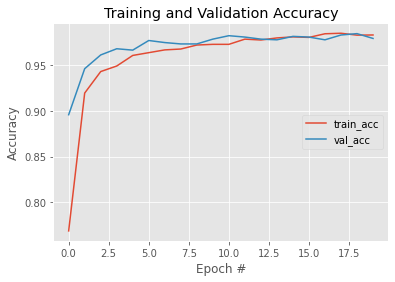

In [ ]:
# plot the training accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="center right")
plt.savefig("plot1.png")

## **Training and Validation  Loss Curve:-**





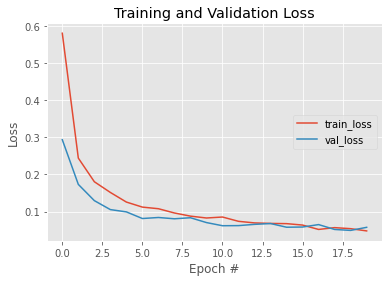

In [ ]:
# plot the validation accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="center right")
plt.savefig("plot3.png")

# **Confusion Matrix**

In [ ]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict.shape


(5327, 3)

In [ ]:
testPredict.shape

(1332, 3)

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred=model.predict(testX)  
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(testY, axis=1)
cm2 = confusion_matrix(y_test, y_pred)
print(cm2)

[[432  11   1]
 [  2 441   1]
 [  0  13 431]]


Text(51.0, 0.5, 'True Labels')

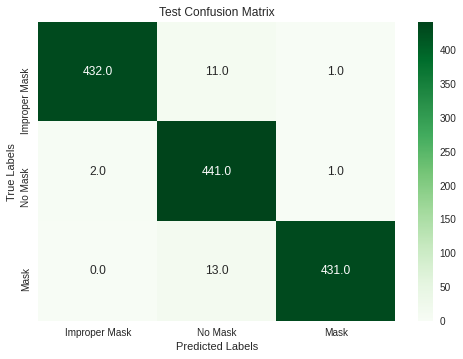

In [ ]:
import seaborn as sn

sn.heatmap(cm2,annot=True,fmt = '.1f',xticklabels=['Improper Mask','No Mask','Mask'],yticklabels=['Improper Mask','No Mask','Mask'],cmap = 'Greens')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# **AUC-ROC Curve**





In [ ]:
# multi-class classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from sklearn.base import BaseEstimator 

# generate 2 class dataset
#X, y = make_classification(n_samples=1000, n_classes=3, n_features=20, n_informative=3, random_state=42)

# split into train/test sets
#, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# fit model
clf = OneVsRestClassifier(LogisticRegression())
clf.fit(trainX, trainY)
pred = clf.predict(testX)
pred_prob = clf.predict_proba(testX)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob, pos_label=i)
    #fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred, pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);   



NameError: ignored

#**ROC-AUC Score**

In [ ]:
from sklearn.metrics import roc_auc_score

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)



In [ ]:
multiclass_roc_auc_score(y_test, y_pred)

0.9842342342342342

#**Model Summary**

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
size = data.size
print(size)

1002365952


In [ ]:
shape = data.shape
print(shape)

(6659, 224, 224, 3)


In [ ]:
len(data)

6659